In [1]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter import IPAdapter

/home/santiagojn/anaconda3/envs/ipa/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
root_path = "/media/raid/santiagojn/IPAdapter/"
base_model_path = root_path + "stable-diffusion-v1-5"
vae_model_path = root_path + "sd-vae-ft-mse"
# image_encoder_path = root_path + "models/image_encoder/"
image_encoder_path = root_path + "image_encoders/factor_serrano_REPORT"
# ip_ckpt = root_path + "models/ip-adapter_sd15.bin"
ip_ckpt = root_path + "results/test_masked-serrano/checkpoint-500/ip_adapter.bin"
device = "cuda"

In [33]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

## Image Variations

In [34]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)
# pipe.to("cuda", torch.float16)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.00it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


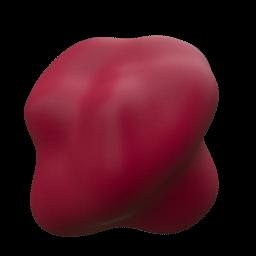

In [49]:
# read image prompt
image = Image.open("assets/images/blob1.jpg")
image.resize((256, 256))

In [36]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device, custom_FVAE=True)

---FORWARD---
Image_embeds torch.Size([1, 20]): tensor([[ 0.1287,  0.4697, -0.8311, -2.1582, -1.2197,  0.5474,  0.1606, -0.2244,
          0.1936,  0.7402, -0.6831,  0.1453, -0.7407,  0.0753, -0.4861,  0.1163,
         -0.9585, -0.2617,  0.1664, -0.3706]], device='cuda:0',
       dtype=torch.float16)
---FORWARD---
Image_embeds torch.Size([1, 20]): tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0', dtype=torch.float16)


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


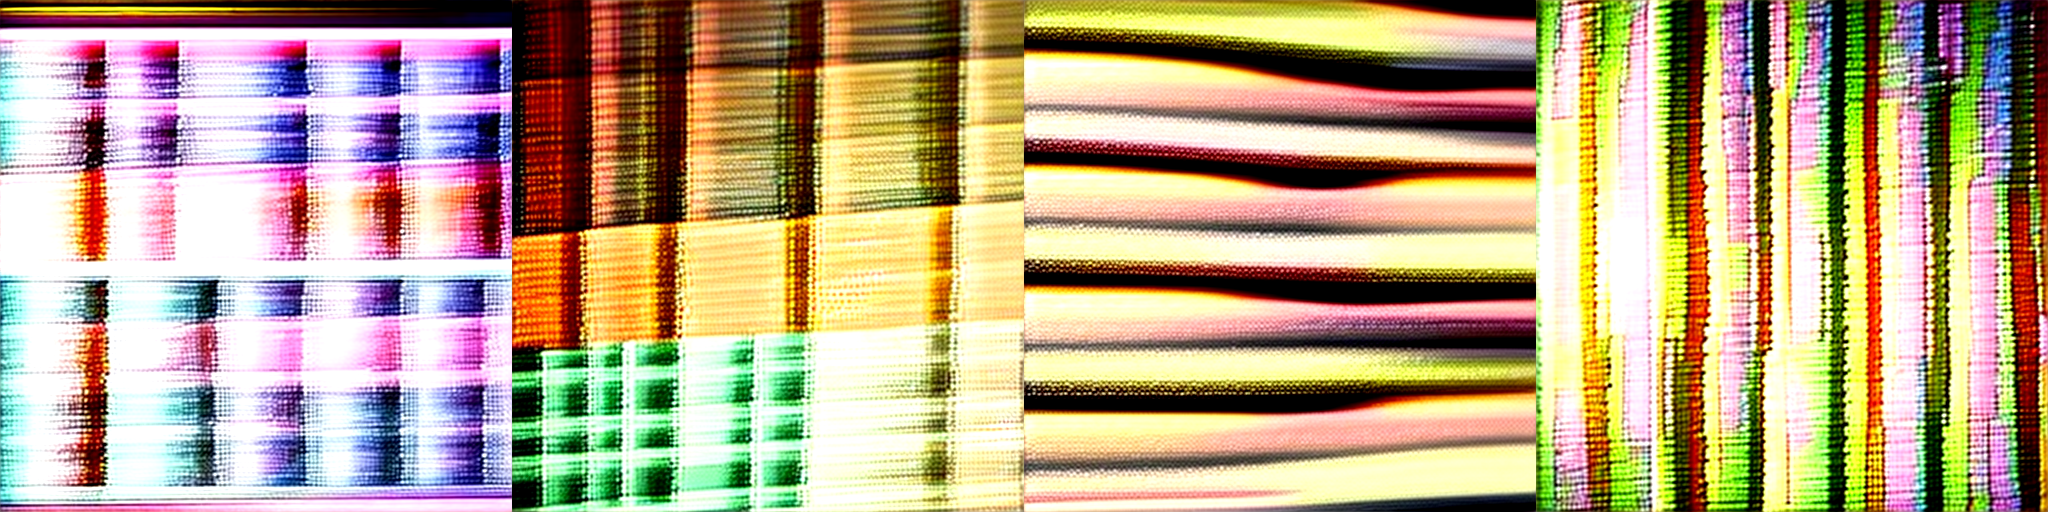

: 

In [50]:
# generate image variations
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=100#, seed=42
            )
grid = image_grid(images, 1, 4)
grid

## Image-to-Image

In [21]:
# load SD Img2Img pipe
del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  7.18it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


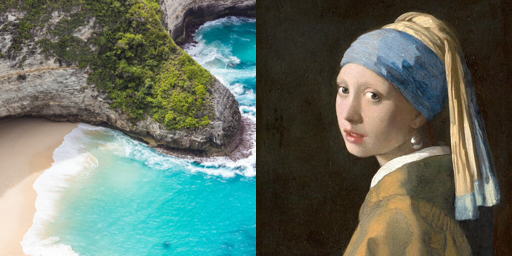

In [22]:
# read image prompt
image = Image.open("assets/images/river.png")
g_image = Image.open("assets/images/vermeer.jpg")
image_grid([image.resize((256, 256)), g_image.resize((256, 256))], 1, 2)

In [23]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

OSError: /media/raid/santiagojn/IPAdapter/image_encoders/factor_serrano_REPORT does not appear to have a file named config.json. Checkout 'https://huggingface.co//media/raid/santiagojn/IPAdapter/image_encoders/factor_serrano_REPORT/tree/main' for available files.

/home/santiagojn/anaconda3/envs/ipa/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py:750: FutureWarning: You have passed 4 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 30/30 [00:03<00:00,  8.50it/s]


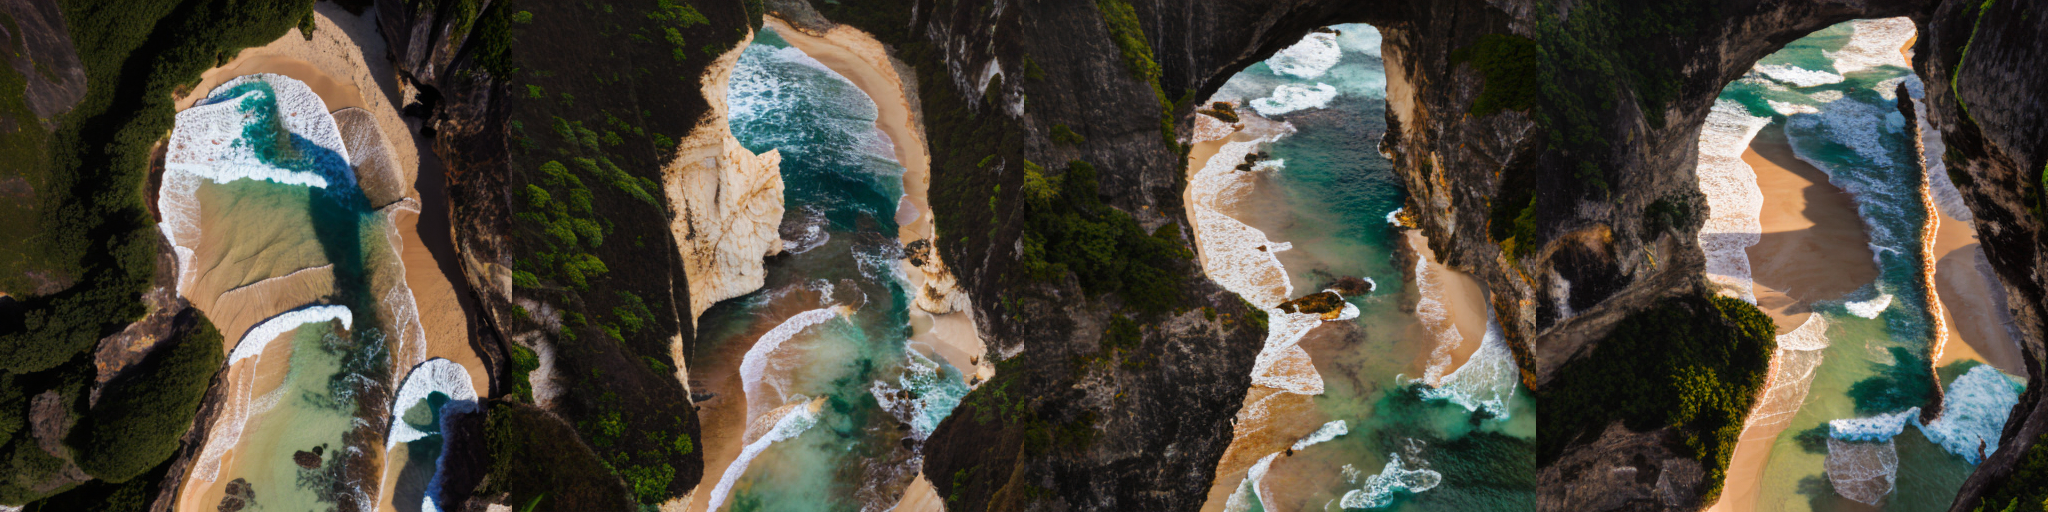

In [ ]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42, image=g_image, strength=0.6)
grid = image_grid(images, 1, 4)
grid

## Inpainting

In [ ]:
# load SD Inpainting pipe
del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionInpaintPipelineLegacy.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]
/home/santiagojn/anaconda3/envs/ipa/lib/python3.8/site-packages/diffusers/pipelines/deprecated/stable_diffusion_variants/pipeline_stable_diffusion_inpaint_legacy.py:141: FutureWarning: The class <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> is deprecated and will be removed in v1.0.0. You can achieve exactly the same functionalityby loading your model into `StableDiffusionInpaintPipeline` instead. See https://github.com/huggingface/diffusers/pull/3533for more information.
  deprecate("legacy is outdated", "1.0.0", deprecation_message, standard_warn=False)
You have disabled the safety checker for <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> by passing `safety_checker=None`. Ensure that you abide to the conditions o

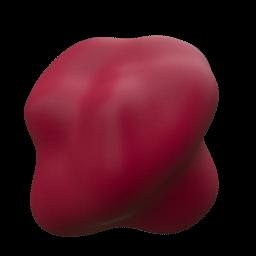

In [ ]:
# read image prompt
image = Image.open("assets/images/blob1.jpg")
image.resize((256, 256))

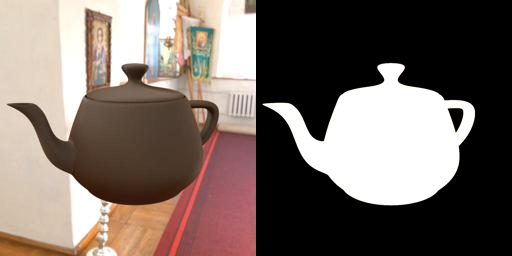

In [ ]:
masked_image = Image.open("assets/inpainting/teapot_image.jpg").resize((256, 256))
mask = Image.open("assets/inpainting/teapot_mask.png").resize((256, 256))
image_grid([masked_image.resize((256, 256)), mask.resize((256, 256))], 1, 2)

In [ ]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:02<00:00, 19.84it/s]


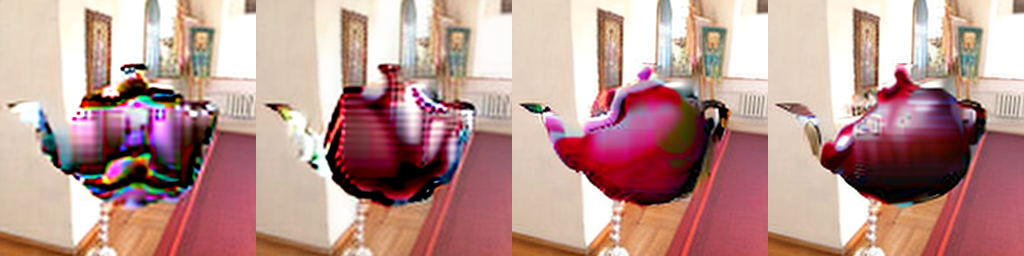

In [ ]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, #seed=-1,
                            image=masked_image, mask_image=mask, strength=0.99, )
grid = image_grid(images, 1, 4)
grid